# Item-Item Top-N Recommendations

In this excercise we will implement a simple top-N recommender, evaluate the algorithms, and then call algorithms from the Surprise package. In top-N recommendations the algorithm is requested to produce a list of N items that the user will be interested in. 
In this particular execercise we will work with an escape room dataset.

First, let's load the dataset, which is already split by time into a training set and a test set:

In [25]:
import pandas as pd
from time import time
import numpy as np
import matplotlib.pyplot as plt


In [26]:

train_set_path = 'resources//train_numerized_with_anon.csv'
test_set_path = 'resources//test_numerized_with_anon.csv'

train_set = pd.read_csv(train_set_path, parse_dates=[3], index_col='index')
test_set = pd.read_csv(test_set_path, parse_dates=[3], index_col='index')

users_in_train = train_set.userID.unique()
test_set = test_set[test_set.userID.isin(users_in_train)]

We can take a look at the structure of the dataset:

In [27]:
pd.set_option('display.max_rows', 100)
display(train_set.head(10))
train_set.rating.value_counts()

,userID,itemID,rating,timestamp
index,,,,
0,0,0,10,11/11/2015
1,1,0,10,11/11/2015
2,2,0,8,11/11/2015
3,3,0,10,11/11/2015
4,4,0,10,11/11/2015
5,5,0,10,11/11/2015
6,6,0,5,11/11/2015
7,7,0,10,11/11/2015
8,8,0,10,11/11/2015


10    25803
9      5131
8      4027
7      2333
6      1162
5       574
4       319
1       244
3       237
2       192
Name: rating, dtype: int64

***
Let's look at the data
***

In [28]:
# are there missing ratings?
print(train_set.rating.isna().sum(), 'missing ratings')

# how many different items do we have in the train set?
print(len(train_set.itemID.unique()), 'different items')

# how many different users?
print(len(train_set.userID.unique()), 'different users')


0 missing ratings
375 different items
20197 different users


In [29]:
display(train_set.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40022 entries, 0 to 40021
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userID     40022 non-null  int64 
 1   itemID     40022 non-null  int64 
 2   rating     40022 non-null  object
 3   timestamp  40022 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


None

itemID
66    741
1     601
76    548
69    547
5     512
0     510
75    504
2     501
74    458
3     455
dtype: int64

<AxesSubplot:>

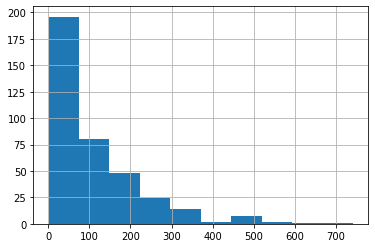

In [34]:
num_ratings_per_item = train_set.pivot_table(index='itemID', aggfunc='size').sort_values(ascending=False)
display(num_ratings_per_item.head(10))
num_ratings_per_item.hist()

## Part 1: Recommend Most Popular Items 

Now we can begin implementing the our first algorithm, that recommends to the user the list of most popular items. Although this is not a personalized approach, in many cases, this is not a bad idea - popular items are popular because everybody choose them, so there is a high likelihood that recommended popular items will be indeed chosen by the user.

In the code below, fill in the missing parts. The algorithm has a training method, where item popularity is computed, and a recommendation method, where the list of popular items.

In [32]:
class MostPopular:

    def __init__(self):
        self.item_ratings_sorted = None
        self.train_set = None

    def learn_model(self, train_set):
        self.train_set = train_set
        item_ratings_sorted = self.train_set.groupby('itemID').count().sort_values('rating', ascending=False)
        self.item_ratings_sorted = item_ratings_sorted.index.values

    def get_top_n_recommendations(self, test_set, top_n):
        result = {}
        already_ranked_items_by_user = self.train_set.groupby('userID')['itemID'].apply(list)
        
        # compute recommendations for each user in test set
        for userID in test_set.userID.unique():
            recommend = [x for x in self.item_ratings_sorted if x not in already_ranked_items_by_user[userID]]
            result[str(userID)] = recommend[:top_n]
            
        return result

Now we can call the most popular algorithm to deliver a list of reocmmendations. The code below prints the list of top 5 recommended items for user with ID 431.

In [33]:
popular = MostPopular()
popular.learn_model(train_set)
popular_recs = popular.get_top_n_recommendations(test_set,top_n=5)
print(popular_recs['431'])
assert popular_recs['431'] == [53, 26, 68, 85, 16], 'Wrong computation of popular items'

[53, 26, 68, 85, 16]


## Part 2 - Item-Item Recommendations

We now learn a slightly more sophisticated model, that uses item-item similarities. Given such a similarity score, we can recommend to a user items that are most similar to the items that the user has chosen in the past. One such useful similarity metric is the Jaccard coefficient. For two items i1 and i2, the Jaccard similarity is the number of users who have chosen both i1 and i2, divided by the number of users who have chosen either i1 or i2. That is, given the list of users who have chosen i1 and the list of users who have chosen i2, the Jaccard similarity is the intersection of the lists, divided by the union of the lists.

In practice, to expedite the recommendation process, and hence reduce online latency, we will compute the item-item co-occurence matrix in the model learning phase. Then, online, when recommendations are requested, we only need to compute for each item that the user has already chosen in the past, the Jaccard scores for the other items.

As the user has chosen several items in the past, we need to aggregate the Jaccard scores. That is, if the user has previously chosen i1 and i2, item i3 has two scores J(i1,i3) and J(i2,i3), and an aggregation of the scores is needed. There are two popular aggregation functions - sum and max. Empirically, max typically has better perfromance.

Fill in the missing parts in the code below.

In [10]:
from tqdm import tqdm
import numpy as np
import operator
from itertools import combinations 
from math import factorial

class Jaccard:

    def __init__(self):
        self.item_ratings_sorted = None
        self.train_set = None
        self.item_item_counts = dict()
        self.item_counts = None

    def learn_model(self, train_set):
        print('Started training')
        self.train_set = train_set
        self.item_counts = self.train_set.groupby('itemID')['userID'].agg('count') #  num users that chose each item
                
        pbar = tqdm(total = len(train_set.userID.unique()))
        
        # Iterate over the users, and for each user and each two items that the user chose, increase the count
        for user in train_set.userID.unique():
            pbar.update(1)

            userData = self.train_set[self.train_set.userID == user]            
            user_unique_items = userData.itemID.tolist()
            
            # find all unique pairs of items the user chose
            unique_pairs = list(combinations(user_unique_items, 2))
            
            # increase count of pair in dictionary
            for (item1, item2) in unique_pairs:
                if (item1, item2) in self.item_item_counts:
                    self.item_item_counts[(item1, item2)] += 1
                elif (item2, item1) in self.item_item_counts:
                    self.item_item_counts[(item2, item1)] += 1
                else:
                    self.item_item_counts[(item1, item2)] = 1
                        
        pbar.close()
        print('Done training')            
            

    def get_top_n_recommendations(self, test_set, top_n):
        print('Started computing recommendations')
        result = {}
        already_ranked_items_by_users = self.train_set.groupby('userID')['itemID'].apply(list)
        
        pbar = tqdm(total=len(test_set.userID.unique()))
                
        #For each user in the test set compute recommendations
        for i, userID in enumerate(test_set.userID.unique()):
            if i % 20 == 0:
                pbar.update(20)
            
            result[str(userID)] = []
            maxvalues = dict()  # maintain for each potential item to recommend its highest Jaccard score
                        
            # find all items the user hasn't chosen (all items minus the one he ranked)
            items_user_did_not_rank = set(self.train_set.itemID.unique()) - set(already_ranked_items_by_users[userID])
            
            # Go over every ranked item
            for item in already_ranked_items_by_users[userID]:
                for unranked_item in items_user_did_not_rank:
                    
                    # Find how many users chose both items from self.item_item_counts
                    if (item, unranked_item) in self.item_item_counts.keys():
                        chose_both  = self.item_item_counts[(item, unranked_item)]
                    elif (unranked_item, item) in self.item_item_counts.keys():
                        chose_both = self.item_item_counts[(unranked_item, item)]
                    else:
                        chose_both = 0
                    
                    jaccard_score = chose_both / (self.item_counts[item] + self.item_counts[unranked_item] - chose_both)
            
                    # update maxvalues
                    if unranked_item in maxvalues.keys():
                        if jaccard_score >  maxvalues[unranked_item]:
                            maxvalues[unranked_item] = jaccard_score
                    else:
                        maxvalues[unranked_item] = jaccard_score
            
            #Now we just take the top N items by decreasing Jaccard
            top_list = sorted(maxvalues.items(), key=lambda kv : -kv[1])
            i=0
            j=0
            while i < top_n and j < len(top_list):
                itemID = top_list[j][0]
                j = j + 1
                result[str(userID)].append(itemID)
                i = i + 1
            
        pbar.close()
        print('Done computing recommendations')
        return result


The code below trains a Jaccard model and generates recommendations. Training will take a while, as we need to iterate over all users, and for each user go over her items in quadratic time.

In [11]:
jaccard = Jaccard()
jaccard.learn_model(train_set)
jaccard_recs = jaccard.get_top_n_recommendations(test_set,top_n=5)


  1%|          | 199/20197 [00:00<00:10, 1984.05it/s]

Started training


100%|██████████| 20197/20197 [00:09<00:00, 2037.46it/s]


Done training
Started computing recommendations


240it [00:09, 24.04it/s]                         

Done computing recommendations


As a side note - as computing the ite-item counts takes a while (especially with Python), we are using here the progress bar from the tqdm package (https://pypi.org/project/tqdm/). You need to install tqdm, or remove the progress bar, which would of course is not needed for the algorithm to run.

We now want to compare the recommendation lists to see which one is better. In top-N recommendations it is popular to computer the Precision@N metric - the portion of recommended items that were chosen by users in the test set. This is typically a reasonable metric for real systems, where one wants to optimize the number of recommended items that are chosen.

We compute Precision@N by comparing the number of recommendations chosen by the users, divided by the number of overall recommendations.

Fill in the missing parts in the code below:

In [13]:
def compute_precision(test_set, recommendations):
   
    hits = 0     #hits is the number of items that were recommended and chosen
    recs = 0     #recs is the total number of recommended items
    
    for u in test_set.userID.unique():
        userData = test_set[test_set.userID == u]
        userRecs = recommendations.get(str(u))
        chosen_by_user = userData['itemID'].values
        
        recs += len(userRecs)
        hits+=len(set(chosen_by_user).intersection(set(userRecs)))
        
    return hits / recs
            

In [14]:
p1 = compute_precision(test_set, jaccard_recs)
p2 = compute_precision(test_set, popular_recs)
print("Jaccard=", p1, "  Popularity=", p2)

Jaccard= 0.03700440528634361   Popularity= 0.027312775330396475


The precision values for this dataset may seem pretty low, but this is typical for many top-N problems. It is important not to compute metrics that hide the true values, such as AUC, but to acknowledge the perfromance of the system in the application.

## Part 4 - Calling Algorithms from the Surprise Package

There are many existing recommendation algorithms available. We will now see how we can call algorithms from the Surprise package. 

The code below adds a wrapper around the algorithm to transform the resulting recommendations into our desired format.

#### NOTE: 
To run the code below you first have to install _surprise_ (http://surpriselib.com/). surprise requires scipy >=1.0, so update if needed.

To install: pip install scikit-surprise or, if you're using anaconda:  conda install -c conda-forge scikit-surprise).  

In [15]:
import sys, string, os
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
import operator
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import PredefinedKFold
from surprise.prediction_algorithms import *


class SurpriseRecMethod():

    #method will be the specific Surprise algorithm that we will call
    def __init__(self, method):
        self.method = method

    def fit(self, train_set):
        self.train_set = train_set


    def get_top_n_recommendations(self, test_set, top_n):
        self.test_set = test_set

        #Surprise requires a slightly different input data format, so we use two different CSVs
        test_path_tmp = "resources//test_file.csv"
        train_path_tmp = "resources//train_file.csv"

        self.train_set.to_csv(train_path_tmp, index=False, header=False)
        self.test_set.to_csv(test_path_tmp, index=False, header=False)

        fold_files = [(train_path_tmp, test_path_tmp)]
        reader = Reader(rating_scale=(1, 10), line_format='user item rating', sep=',')
        data = Dataset.load_from_folds(fold_files, reader=reader)

        for trainset, testset in PredefinedKFold().split(data):
            self.method.fit(trainset)

        already_ranked_items_by_users = self.train_set.groupby('userID')['itemID'].apply(list)

        recommendations = {}
        pbar = tqdm(total=len(self.test_set.userID.unique()))
        for userID in self.test_set.userID.unique():
            pbar.update(1)

            if userID not in self.train_set.userID.unique():
                recommendations[str(userID)] = []
                continue

            items_expected_ranking = {}
            for itemID in self.train_set.itemID.unique():
                if itemID in already_ranked_items_by_users[userID]:
                    continue
                #We call here the specific Surprise method that we use for this model
                #The method predicts a score for a given item
                predicted = self.method.predict(str(userID), str(itemID), clip=False)
                items_expected_ranking[itemID] = predicted[3]
                
            #Now we just sort by decreasing scores and take the top N
            sorted_predictions = sorted(items_expected_ranking.items(), key=operator.itemgetter(1))
            sorted_predictions.reverse()
            sorted_predictions = [x[0] for x in sorted_predictions]
            user_recommendations = sorted_predictions[:top_n]
            recommendations[str(userID)] = user_recommendations
        pbar.close()
        return recommendations


The code below calls the package with the SlopeOne algorithm.

In [16]:
modelSlopeOne = SurpriseRecMethod(SlopeOne())
modelSlopeOne.fit(train_set)
recSlopeOne = modelSlopeOne.get_top_n_recommendations(test_set, 5)
p3 = compute_precision(test_set,recSlopeOne)

100%|██████████| 227/227 [00:01<00:00, 134.47it/s]


The code below calls the package with a nearest neighbor user-item recommendation method.

In [17]:
modelKNNUser = SurpriseRecMethod(KNNBasic(sim_options={'name': 'cosine', 'user_based': True}, random_state = 42))
modelKNNUser.fit(train_set)
recKNNUser = modelKNNUser.get_top_n_recommendations(test_set, 5)
p4 = compute_precision(test_set,recKNNUser)

Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|██████████| 227/227 [00:06<00:00, 35.55it/s]


Let us look at the results of all algorithms together:

In [18]:
pd.DataFrame.from_dict({'Jaccard':p1,'Popularity':p2,'SlopeOne':p3,'User KNN':p4}, orient='index',columns=['Precision'])

,Precision
Jaccard,0.037004
Popularity,0.027313
SlopeOne,0.032599
User KNN,0.075771


Try the NMF (non-negative matrix factorization) algorithms from the package - https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF.


In [19]:
# NMF with default parameters

modelNMFUser = SurpriseRecMethod(NMF(random_state = 42))
modelNMFUser.fit(train_set)
recNMFUser = modelNMFUser.get_top_n_recommendations(test_set, 5)
p5 = compute_precision(test_set,recNMFUser)
print(p5)


100%|██████████| 227/227 [00:01<00:00, 206.34it/s]


0.03700440528634361


***
let's try to improve NMF by tuning some hyper-paramters
***

100%|██████████| 5198/5198 [00:08<00:00, 591.88it/s]


2 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 582.73it/s]


3 factors, percision = 0.006


100%|██████████| 5198/5198 [00:08<00:00, 587.27it/s]


4 factors, percision = 0.006


100%|██████████| 5198/5198 [00:08<00:00, 583.29it/s]


5 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 584.83it/s]


6 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 578.03it/s]


7 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 582.68it/s]


8 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 587.49it/s]


9 factors, percision = 0.004


100%|██████████| 5198/5198 [00:08<00:00, 581.80it/s]


10 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 581.73it/s]


11 factors, percision = 0.003


100%|██████████| 5198/5198 [00:08<00:00, 581.72it/s]


12 factors, percision = 0.005


100%|██████████| 5198/5198 [00:08<00:00, 581.52it/s]


13 factors, percision = 0.004


100%|██████████| 5198/5198 [00:08<00:00, 581.65it/s]


14 factors, percision = 0.004


100%|██████████| 5198/5198 [00:08<00:00, 579.35it/s]


15 factors, percision = 0.004
best results using 3


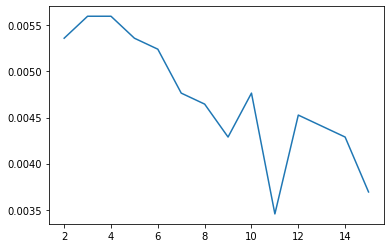

In [20]:
# let's split the train data to train and cross validation so we can adjust the hyper-parameters

mask = np.random.rand(len(train_set)) < 0.8
train_ = train_set[mask]
cv_ = train_set[~mask]

percision_vec = []

factors = range(2,16)
for i in factors:
    modelNMFUser = SurpriseRecMethod(NMF(n_factors=i, biased = True, random_state = 42))
    modelNMFUser.fit(train_)
    recNMFUser = modelNMFUser.get_top_n_recommendations(cv_, 5)
    perc = compute_precision(cv_,recNMFUser)
    print(f'{i} factors, percision = {perc:.3f}') 
    percision_vec.append(perc)
    
    
best_factor = factors[np.argmax(percision_vec)]
print('best results using', best_factor)

plt.plot(factors, percision_vec)
    

***
Let's use the best n_factors and use it 
***

In [23]:

modelNMFUser = SurpriseRecMethod(NMF(n_factors = best_factor, biased = True, random_state = 42))
modelNMFUser.fit(train_set)
recNMFUser = modelNMFUser.get_top_n_recommendations(test_set, 5)
p5 = compute_precision(test_set,recNMFUser)


100%|██████████| 227/227 [00:01<00:00, 186.77it/s]


In [24]:
pd.DataFrame.from_dict({'Jaccard':p1,'Popularity':p2,'SlopeOne':p3,'User KNN':p4, 'NMF':p5}, orient='index',columns=['Precision'])

,Precision
Jaccard,0.037004
Popularity,0.027313
SlopeOne,0.032599
User KNN,0.075771
NMF,0.055507


***

We can see the tuned version of NMF has higher accuracy than the default one, but it's still not as good as user KNN.
***

For this particular dataset, the user nearest neighbor approach worked best. Hence, should we need to choose a method to put online, we should go with this method.